In [1]:
# import usual libraries for machine learing and data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC

# get the data

In [2]:
df = pd.read_csv('./Dataset/heart_encode_scaled.csv')
df.head()

,Age,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
0,0.244898,0.444444,0.633540,0.0,0.5,0.770992,0.0,0.000000,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.428571,0.629630,0.295031,0.0,0.5,0.648855,0.0,0.161290,0.5,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.183673,0.351852,0.614907,0.0,1.0,0.206107,0.0,0.000000,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.408163,0.425926,0.400621,0.0,0.5,0.282443,1.0,0.241935,0.5,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.530612,0.537037,0.341615,0.0,0.5,0.389313,0.0,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [3]:
# split the data into training and testing data using train_test_split

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# test svc model from sklearn

In [5]:
Linsvc = LinearSVC()
Linsvc.fit(X_train, y_train)

LinearSVC()

In [6]:
y_pred = Linsvc.predict(X_test)

In [7]:
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8367346938775511


<AxesSubplot:>

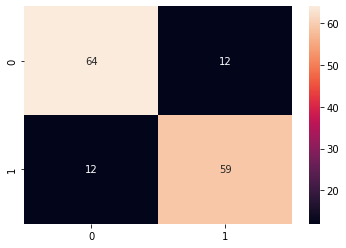

In [16]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)



# creating my own

In [28]:
import cvxopt
from __future__ import division, print_function
cvxopt.solvers.options['show_progress'] = False

class SupportVectorMachine():
    def kernel(self, gamma):
        """rbf kernel"""
        def f(x1, x2):
          distance = np.linalg.norm(x1 - x2) ** 2
          return np.exp(-gamma * distance)
        return f

    def __init__(self, C=1, power=4, gamma=None, coef=4):
        self.C = C
        self.power = power
        self.gamma = gamma
        self.coef = coef
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None

    def fit(self, X, y):

        n_samples, n_features = np.shape(X)

        # Set gamma to 1/n_features by default
        if not self.gamma:
            self.gamma = 1 / n_features

        # Initialize kernel method with parameters
        self.kernel = self.kernel(gamma=self.gamma)

        # Calculate kernel matrix
        kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i, j] = self.kernel(X.iloc[i], X.iloc[j])

        # Define the quadratic optimization problem
        P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')

        if not self.C:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            h_max = cvxopt.matrix(np.zeros(n_samples))
            h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
            h = cvxopt.matrix(np.vstack((h_max, h_min)))

        # Solve the quadratic optimization problem using cvxopt
        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        lagr_mult = np.ravel(minimization['x'])

        # Extract support vectors
        # Get indexes of non-zero lagr. multipiers
        idx = lagr_mult > 1e-7
        # Get the corresponding lagr. multipliers
        self.lagr_multipliers = lagr_mult[idx]
        # Get the samples that will act as support vectors
        self.support_vectors = X[idx]
        # Get the corresponding labels
        self.support_vector_labels = y[idx]

        # Calculate intercept with first support vector
        self.intercept = self.support_vector_labels[0]
        for i in range(len(self.lagr_multipliers)):
            self.intercept -= self.lagr_multipliers[i] * self.support_vector_labels.iloc[
                i] * self.kernel(self.support_vectors.iloc[i], self.support_vectors.iloc[0])

    def predict(self, X):
        y_pred = []
        # Iterate through list of samples and make predictions
        for sample in X:
            prediction = 0
            # Determine the label of the sample by the support vectors
            for i in range(len(self.lagr_multipliers)):
                prediction += self.lagr_multipliers[i] * self.support_vector_labels.iloc[
                    i] * self.kernel(self.support_vectors.iloc[i], sample)
            prediction += self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)


In [29]:
svm = SupportVectorMachine()
svm.fit(X_train, y_train)

In [31]:
y_pred = svm.predict(X_test)

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')